In [1]:
def one_hot(vector, max_int=10):
    return np.eye(max_int)[vector]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)
Label for first image: 7
['digits', 'labels']
Shape of input data: (10380, 784)
Shape of input labels: (10380,)
Label for first image: 1
['digits', 'labels']
Shape of test input data: (2580, 784)
Shape of combined images (65380, 784)
Shape of combined labels (65380, 10)


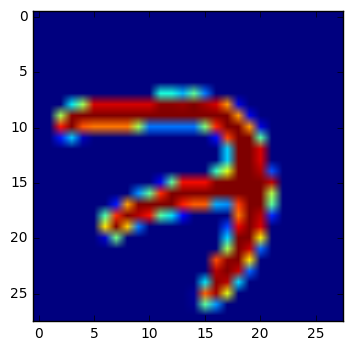

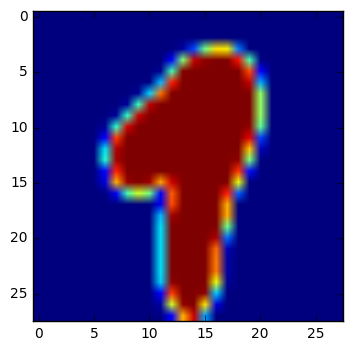

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print(mnist.train.images.shape)

mnist_reshape_first = np.asarray(mnist.train.images)[0,:].reshape(28,28)
plt.imshow(mnist_reshape_first)
print("Label for first image:", np.asarray(mnist.train.labels)[0].argmax())

train_file = np.load('auTrain.npz')
print(train_file.keys())  # ['digits', 'labels']
images = train_file['digits']
labels = train_file['labels']
print('Shape of input data: %s' % (images.shape,))
print('Shape of input labels: %s' % (labels.shape,))
plt.figure()
plt.imshow(images[0,:].reshape(28, 28))
print("Label for first image:", labels[0])

test_file = np.load('auTest.npz')
print(test_file.keys())
images_test = test_file['digits']
labels_test = test_file['labels']
print('Shape of test input data: %s' % (images_test.shape,))

#Append auDigits to mnist data
images_combine = np.concatenate((mnist.train.images, images), axis=0)
print("Shape of combined images", images_combine.shape)

label_mnist_transform = one_hot(labels)
labels_combine = np.concatenate((mnist.train.labels, label_mnist_transform), axis=0)
print("Shape of combined labels", labels_combine.shape)

In [9]:
# Tensorflow

sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])


def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')




# Building first layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Building second layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


# Read
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-4
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 100, 0.96, staircase=True)
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy, global_step=global_step)


sess.run(tf.initialize_all_variables())


batch_size = 500
data_points = images_combine.shape[0]
current_data_point_state = data_points
for i in range(2000):
    if current_data_point_state + batch_size > data_points:
        perm = np.random.permutation(data_points)
        images_combine = images_combine[perm,:]
        labels_combine = labels_combine[perm,:]
        current_data_point_state = 0
        print("Learning rate: ", learning_rate.eval())

    
    images_batch = images_combine[current_data_point_state:current_data_point_state + batch_size,:]
    labels_batch = labels_combine[current_data_point_state:current_data_point_state + batch_size,:]
    current_data_point_state = current_data_point_state + batch_size
    
    if i%10 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:images_batch, y_: labels_batch, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    if i%100 == 0:
        test_accuracy = accuracy.eval(feed_dict={x:images_test, y_: one_hot(labels_test), keep_prob: 1.0})
        print("step %d, test accuracy %g"%(i, test_accuracy))
    
    train_step.run(feed_dict={x: images_batch, y_: labels_batch, keep_prob: 0.5})
    
 
  


#print("test accuracy %g"%accuracy.eval(feed_dict={
  #  x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Learning rate:  0.0001
step 0, training accuracy 0.07
step 0, test accuracy 0.077907
step 10, training accuracy 0.232
step 20, training accuracy 0.548
step 30, training accuracy 0.586
step 40, training accuracy 0.706
step 50, training accuracy 0.758
step 60, training accuracy 0.774
step 70, training accuracy 0.82
step 80, training accuracy 0.84
step 90, training accuracy 0.86
step 100, training accuracy 0.894
step 100, test accuracy 0.791085
step 110, training accuracy 0.848
step 120, training accuracy 0.876
Learning rate:  9.6e-05
step 130, training accuracy 0.902
step 140, training accuracy 0.9
step 150, training accuracy 0.896
step 160, training accuracy 0.898
step 170, training accuracy 0.912
step 180, training accuracy 0.908
step 190, training accuracy 0.912
step 200, training accuracy 0.93
step 200, test accuracy 0.860078
step 210, training accuracy 0.914
step 220, training accuracy 0.936
step 230, training accuracy 0.924
step 240, training accuracy 0.91
step 250, training accura